In [1]:
#Import ee and required packages
import ee
ee.Initialize()
import pandas as pd 
import numpy as np
import glob
import geopandas as gpd
import time
import configparser

from src.gee_funs import *
import src.build_annual_cube as bac
import src.preprocess_points as pp
import src.covariates_exist as ce



In [2]:
# Variables are defined in aisconfig.ini
# 

config = configparser.ConfigParser()
config.read('aisconfig.ini')

# Define the state that presence/absence data is in
state = config['WHENWHERE']['STATE']
state_abbrevs = {
    'Montana' : 'MT'
}


# Define your desired time range
start_year = int(config['WHENWHERE']['START_YEAR'])
end_year = int(config['WHENWHERE']['END_YEAR'])
years = range(start_year, end_year)
years_strings = [str(y) for y in years]

# Define a path in GEE where
gee_path = config['GEEPATHS']['GEE_PATH']

# Define locations in GEE where presence/absence data and thinned data live
ais_point_path = config['GEEPATHS']['AIS_POINT_PATH']
ais_thinned_point_path = config['GEEPATHS']['AIS_THINNED_POINT_PATH']


# Define the export location for the covariate assets
# NOTE: Renamed from assetId to covariate_folder
covariate_folder = config['GEEPATHS']['ASSETID']

# Define the export locations for the ML model training data
trainingdata = config['LOCALPATHS']['TRAININGDATA']
trainingglob = config['LOCALPATHS']['TRAININGGLOB']

# Define the export loction for (decade files)
decade1 = config['LOCALPATHS']['DECADE1']
decade2 = config['LOCALPATHS']['DECADE2'] 

In [3]:
# Choose which parts of the pipeline to run
# These switches effectively (and crudely) turn off parts of the script

# Spatial thinning should only be performed once for a presence/absence set, the result can be reused after that
run_spatial_thinning = False

# Covariate assets shouldn't change from dataset to dataset, unless you change covariates or timeframes
# Making the assets takes upwards of 2-6 hours
make_covariates = False

In [4]:
# This only runs if run_spatial_thinning (defined above) is set to true
# If you already have a thinned dataset, skip to Define Modular Variables below

#Define GEE asset/location of desired dataset 
#(Formatted CSV must be uploaded to your GEE assets with Lat/Long columns defined before starting)
if run_spatial_thinning:
    pp.spatially_thin(ais_point_path, start_year, end_year)

In [5]:
# If you have a spatially thinned data set, start here after initializing ee
# embed observation Year as system:start_time for thinned dataset 
# We have had to add this "Year Column" manually to the datasets.  
# Make sure your dataset has correct column headings
SThin = ee.FeatureCollection(ais_thinned_point_path).map(embed_date)

In [6]:
# Define geometry by changing state name so we can export the whole state at once
state_geometry = ee.FeatureCollection("TIGER/2016/States").filter(ee.Filter.eq('NAME',state)).geometry()

# Choose state to clip HUC by. Change Abbreviation to match dataset 
#Enter state full name for X (i.e., Illinois/ look at dataset for formats for this stuff)
HUC_clip = ee.FeatureCollection("USGS/WBD/2017/HUC12").filter(ee.Filter.eq('states',state_abbrevs[state]))

In [7]:
#Skip this step if you already have them stored in GEE
#Export Yearly Covariate Images

#========================================================
# Run covariate algorithm and build a list of images
# with each image corresponding to each year and each band corresponding to each covariate
#========================================================
if make_covariates:
    banded_images_list = bac.build_all_cubes(start_year, end_year)

    # Export each image within the for loop
    for i,y in zip(range(len(years_strings)), years_strings):
        print("Starting", y)
        img = ee.Image(banded_images_list.get(ee.Number(i)))
        export = ee.batch.Export.image.toAsset(
            image = img,
            description = 'covariates'+y,
            covariate_folder = covariate_folder + y, 
            region = ee.Geometry(state_geometry),
            scale =  100,
            maxPixels = 1e13)
        export.start()

        print(y,"status:    ", export.status()['state'])

        # Wait for 30 seconds so that the export['state'] gives insightful information
        time.sleep(15)
        # TODO better handle status messages
        # while (export.status()['state'] == 'READY'):
        #    time.sleep(15)

        print(y,"status:    ", export.status()['state'])

        # If this status is "RUNNING", then there are no egretious syntax errors. 
        # However, it is still possible that these export commands fail after more than 30 seconds.
        # In that case, it is likely that there is a Computation Time Out Error (remember exporting the annual stacks)
        time.sleep(15)
        print(y,"status:    ", export.status()['state'])


In [8]:
if (not ce.covariates_exist(years, gee_path + 'covariates/')):
    print('WARNING: expected covariate assets were not found in GEE')
else:
    print('expected covariate assets were found, please PROCEED')

assets_found:  ['covariates2002', 'covariates2003', 'covariates2004', 'covariates2005', 'covariates2006', 'covariates2007', 'covariates2008', 'covariates2009', 'covariates2010', 'covariates2011', 'covariates2012', 'covariates2013', 'covariates2014', 'covariates2015', 'covariates2016', 'covariates2017', '']
expected_assets:  ['covariates2002', 'covariates2003', 'covariates2004', 'covariates2005', 'covariates2006', 'covariates2007', 'covariates2008', 'covariates2009', 'covariates2010', 'covariates2011', 'covariates2012', 'covariates2013']
expected covariate assets were found, please PROCEED


In [9]:
#Start Here if you have yearly covariates created

#Export training CSVs
## Reduce Regions from existing images

# COVARIATE IMAGES  
images = list(map(lambda x: ee.Image(covariate_folder + str(x)), years))

for i in range(len(years)):
    print("Starting", start_year+i)
    
    data = reduce_HUCS(images[i],SThin,HUC_clip) 
    
    ## PYTHON API MAGIC!! LOOK HERE
    my_csv = pd.DataFrame([x['properties'] for x in data.getInfo()['features']])
    
    # From there, we can write it directly to our directory and stitch it together afterwards
    my_csv.to_csv((trainingdata) + str(2002+i) + '.csv', index=False) 
    print("Finished", start_year+i)

Starting 2002
Finished 2002
Starting 2003
Finished 2003
Starting 2004
Finished 2004
Starting 2005
Finished 2005
Starting 2006
Finished 2006
Starting 2007
Finished 2007
Starting 2008
Finished 2008
Starting 2009
Finished 2009
Starting 2010
Finished 2010
Starting 2011
Finished 2011
Starting 2012
Finished 2012
Starting 2013
Finished 2013


In [10]:
#export the information that we will use to project habitat suitability. 
#Decades were convenient for RBT, but not other taxa with less data/ we can change.
# Change to match dataset
# maybe we should think about 2 and 5 year bins due to limitations of datasets for some 
# taxa / to make more useful for managers

# Writes output to ./datasets/decade
 
write_predictions_input_csv(images[:5], decade1, HUC_clip)  

write_predictions_input_csv(images[5:], decade2, HUC_clip)

Fitting MLPClassifier
MLPClassifier fit.
Fitting GradientBoostingClassifier
GradientBoostingClassifier fit.
Fitting DecisionTreeClassifier
DecisionTreeClassifier fit.
Fitting RandomForestClassifier
RandomForestClassifier fit.
Fitting LogisticRegression
LogisticRegression fit.
VC accuracy score: 0.781431334622824 
VC confusion matrix: 
[[180  64]
 [ 49 224]]
Considering RandomForestClassifier(random_state=73)
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Considering LogisticRegression(max_iter=10000, random_state=73)
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 

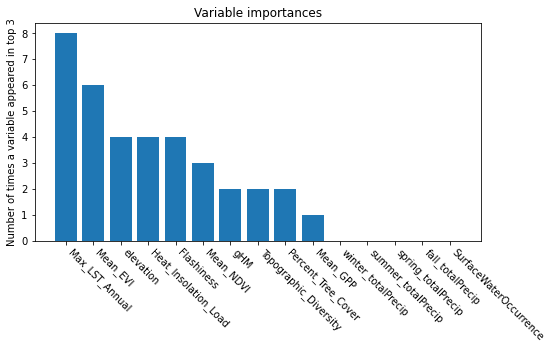

In [11]:
import src.ml_script